<div style = "text-align:center; font-size: 28px; font-weight: bold;"> Predictive Service Delay Management for CTA Trains</div>
<br>


This notebook reflects the necessary steps taken to arrive at a functioning predictive model for the Chicago Transit Authority (CTA).

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Import the Dataset

The dataset is based on real-time data, and is sourced from two separate APIs, the CTA Train Tracker API, and TomTom's Traffic Flow RESTful API.

In [2]:
# The dataset has no column headers, so we are applying column labels based on the API script used to scrape the data
column_labels = [
    "station_id", "line", "predicted_time", "arrival_time", 
    "isSch", "isFlt", "isDly", 
    "station_name", "destination_name", "lat", "long", 
    "free_flow_speed", "current_speed"
]

df = pd.read_csv("combined_data.csv", header = None, names = column_labels)

In [3]:
df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
98750,41300,Red,20230819 17:52:50,20230819 17:55:50,0,0,0,Loyola,Howard,41.98350,-87.65884,14,6
37808,41220,Brn,20230810 23:14:48,20230810 23:21:48,0,0,0,Fullerton,Loop,41.94381,-87.66362,16,16
68296,40960,Org,20230811 21:51:11,20230811 21:54:11,0,0,0,Pulaski,Midway,41.80441,-87.70068,24,24
18380,40190,Red,20230810 16:55:59,20230810 17:15:59,0,0,0,Sox-35th,95th/Dan Ryan,41.91336,-87.65249,19,6
100468,41010,Brn,20230819 18:13:28,20230819 18:26:28,0,0,0,Rockwell,Kimball,41.94070,-87.65341,16,16


Some of these column headers may be hard to decipher. Let's clarify what they mean.

Per the CTA Train Tracker API:

**predicted_time** = "Date-time format stamp for when the prediction was generated:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**arrival_time** = "Date-time format stamp for when a train is expected to arrive/depart:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**isSch** = "Boolean flag to indicate whether this is a live prediction or based on
schedule in lieu of live data"

**isFlt** = "Boolean flag to indicate whether a potential fault has been detected"

>"The **isFlt** element in the results indicates what we call a “schedule fault” in the context of Train Tracker.
A fault on an ETA that is schedule-based (isSch=1) indicates that the scheduled arrival time given
might not be feasible to serve due to the lack of a scheduled departure having occurred."

**isDly** = "Boolean flag to indicate whether a train is considered “delayed” in Train
Tracker"

**lat** = "Latitude position of the train in decimal degrees"

**long** = "Longitude position of the train in decimal degrees"

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

<div style = "text-align:center; font-size: 24px; font-weight: bold;"> Exploratory Data Analysis (EDA)</div>


Now, from these points of clarity, we can make several observations.
First, let's see how many already-classified delays there are in this dataset.

In [4]:
df['isDly'].value_counts()

0    107752
1       530
Name: isDly, dtype: int64

Out of more than **100,000** total train-tracking instances in this dataset, only around **500** of them are **delay-positive**. 

Per the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track
circuit to the next and identifies delays if a train appears to not be moving."

Next, let's see how many instances are based on schedule or have a potential fault. 

In [5]:
df['isSch'].value_counts()

0    108282
Name: isSch, dtype: int64

In [6]:
df['isFlt'].value_counts()

0    108282
Name: isFlt, dtype: int64

Out of the entire dataset, every train so far is based on live predictions and has not had a fault. 

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now, let's return to delays, and analyze them further. Let's see how many recorded delays there are for every specific line.  </div>

>For those who are not native to Chicago, the city's train system consists of multiple colored lines, each of which is associated with a color name.

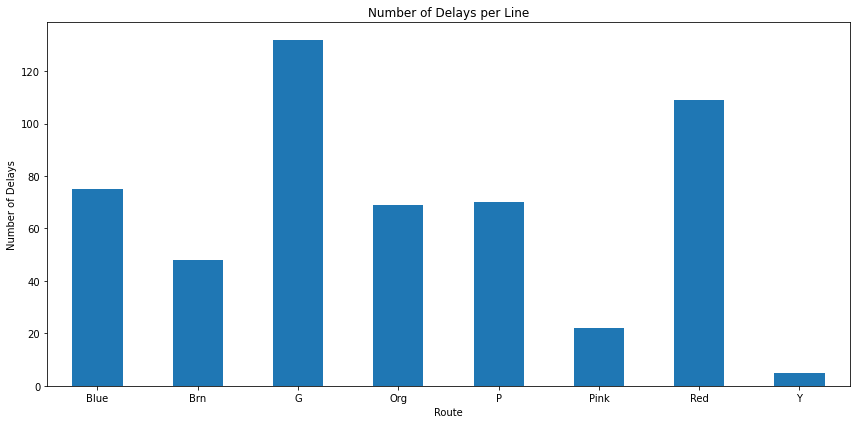

In [7]:
route_delay_counts = df.groupby('line')['isDly'].sum()

plt.figure(figsize = (12,6))
route_delay_counts.plot(kind = 'bar')
plt.xlabel('Route')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Line')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's analyze delays per station. </div>

Station ID with the most delays: 40100
Delay count: 13


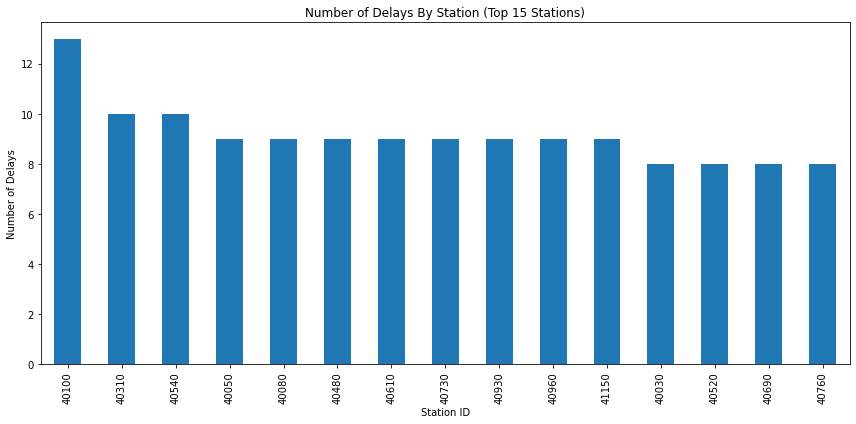

In [8]:
station_delay_counts = df.groupby('station_id')['isDly'].sum()

most_delay_station = station_delay_counts.idxmax()

most_delay_station

most_delay_count = station_delay_counts.loc[most_delay_station]

print("Station ID with the most delays:", most_delay_station)
print("Delay count:", most_delay_count)

#------------------------------------------------------------------

top_n = 15
top_delay_stations = station_delay_counts.nlargest(top_n).index

plt.figure(figsize = (12,6))
station_delay_counts.loc[top_delay_stations].plot(kind = 'bar', stacked = True)
plt.xlabel('Station ID')
plt.ylabel('Number of Delays')
plt.title(f"Number of Delays By Station (Top {top_n} Stations)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's look at delays per hour. </div>

In [9]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_delays = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count delays for each hour
hourly_delays = hourly_delays.merge(df.groupby(df['predicted_time'].dt.hour)['isDly'].sum().reset_index(), 
                                    how = 'left', left_on = 'hour_of_day', right_on = 'predicted_time')

# Fill NaN values with 0 (no delays)
hourly_delays['isDly'] = hourly_delays['isDly'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_delays.drop(columns=['predicted_time'], inplace = True)

# Rename columns
hourly_delays.columns = ['hour_of_day', 'number_of_delays']

# Print the new DataFrame
hourly_delays

,hour_of_day,number_of_delays
0,0,19
1,1,19
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


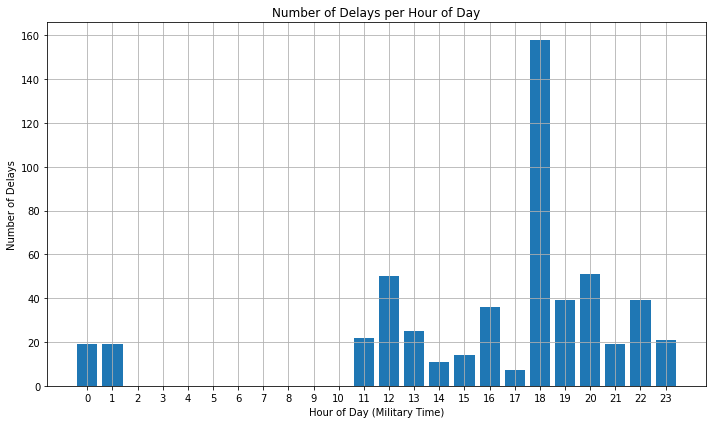

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_delays['hour_of_day'], hourly_delays['number_of_delays'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Hour of Day')
plt.xticks(all_hours)
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align:center; font-size: 24px; font-weight: bold;"> Data Preprocessing </div>
<br style="line-height: 3px;">
<div style="text-align:center; font-size: 18px; font-weight: normal;"> Feature Engineering </div>

To gain further insight into the characteristics of train delays, we can **engineer new columns** that can potentially enhance the predictive power of our machine learning model.

For instance, logically, the difference between **the time a particular prediction is generated** for when a train would arrive ('predicted_time' column), and **the time for when the train is predicted to arrive** ('arrival_time'), can be understood as time an individual would have to wait until the train arrives onto the platform, otherwise known as the **wait time**.

So let's make a new column for how long the wait will be. We can call this new column, "wait_minutes".

In [11]:
# Convert 'predicted_time' and 'arrival_time' columns to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])
df['arrival_time'] = pd.to_datetime(df['arrival_time'])

# Calculate the difference between 'arrival_time' and 'predicted_time' in minutes
df['wait_minutes'] = (df['arrival_time'] - df['predicted_time']).dt.total_seconds() / 60

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'arrival_time'
arrival_time_index = column_names.index('arrival_time')

# Move 'wait_minutes' right after 'arrival_time'
column_names.insert(arrival_time_index + 1, column_names.pop(column_names.index('wait_minutes')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
16332,40280,G,2023-08-10 16:32:57,2023-08-10 17:02:57,30.0,0,0,0,Central,Harlem/Lake,41.86004,-87.62647,19,19
74912,40820,Blue,2023-08-13 18:21:15,2023-08-13 18:33:15,12.0,0,0,0,Rosemont,O'Hare,41.97063,-87.76089,60,19
92042,40040,Org,2023-08-17 22:21:58,2023-08-17 22:47:58,26.0,0,0,0,Quincy,Midway,41.79986,-87.72453,20,20
86713,40890,Blue,2023-08-15 23:08:38,2023-08-15 23:17:38,9.0,0,0,0,O'Hare,O'Hare,41.98457,-87.83116,70,70
71842,40740,Pink,2023-08-12 22:19:57,2023-08-12 22:24:57,5.0,0,0,0,Western,54th/Cermak,41.87178,-87.66955,17,12


Now, we have the wait time (in minutes) for every instance of a train-arrival prediction. Next, let's get the **average wait time for every train station**, and name the column 'station_avg_wait'.

In [12]:
# Group the data by 'station_id' and calculate the average delay time for each station
df['station_avg_wait'] = df.groupby('station_id')['wait_minutes'].transform('mean')

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'wait_minutes'
wait_minutes_index = column_names.index('wait_minutes')

# Move 'station_avg_wait' right after 'wait_minutes'
column_names.insert(wait_minutes_index + 1, column_names.pop(column_names.index('station_avg_wait')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
46962,41300,Red,2023-08-11 13:02:57,2023-08-11 13:04:57,2.0,22.004552,0,0,0,Loyola,95th/Dan Ryan,42.00836,-87.66591,22,22
85945,40360,Brn,2023-08-15 23:00:50,2023-08-15 23:27:50,27.0,24.301237,0,0,0,Southport,Kimball,41.87810,-87.63372,14,14
18560,40590,Blue,2023-08-10 16:56:12,2023-08-10 17:17:12,21.0,13.513514,0,0,0,Damen,Forest Park,41.98236,-87.80416,65,20
11052,41130,Org,2023-08-10 15:14:46,2023-08-10 15:32:46,18.0,18.224138,0,0,1,Halsted,Midway,41.87691,-87.62820,11,6
25031,40870,Brn,2023-08-10 18:30:58,2023-08-10 18:47:58,17.0,27.154179,0,0,0,Francisco,Kimball,41.93466,-87.65321,17,14


Awesome. Now we have the wait time of every individual train-arrival prediction, compared to the average wait time for train-arrival predictions in the corresponding train stations. 

Below is a visual of this comparison for any station of interest. Simply run the cell and provide an station ID input.

List of unique station IDs:
[40260 40380 41700 40680 40850 40160 40040 40730 40460 40330 41400 41160
 41220 41120 41320 40820 40960 41020 40910 40740 40310 40670 40220 41480
 41080 41230 41130 41000 41690 41450 40710 40490 41060 40190 40170 40320
 40660 40830 40210 40120 40590 40530 41070 41040 41150 41170 40510 40250
 40540 41500 40150 40030 40550 40880 40240 40070 40560 40010 40020 40050
 40060 40080 40090 40100 40130 40180 40230 40270 40280 40290 40300 40360
 40370 40390 40400 40420 40440 40450 40480 40520 40570 40580 40600 40610
 40630 40650 40690 40700 40720 40750 40760 40780 40790 40800 40840 40870
 40890 40900 40920 40930 40940 40970 40980 40990 41010 41030 41050 41090
 41140 41180 41190 41200 41210 41240 41250 41260 41270 41280 41290 41300
 41310 41330 41350 41360 41380 41410 41420 41430 41440 41460 41490 41510
 41660 41670 40140 41680 40810]

Enter a station ID from the selection above to plot its 'wait_minutes' distribution: 40240


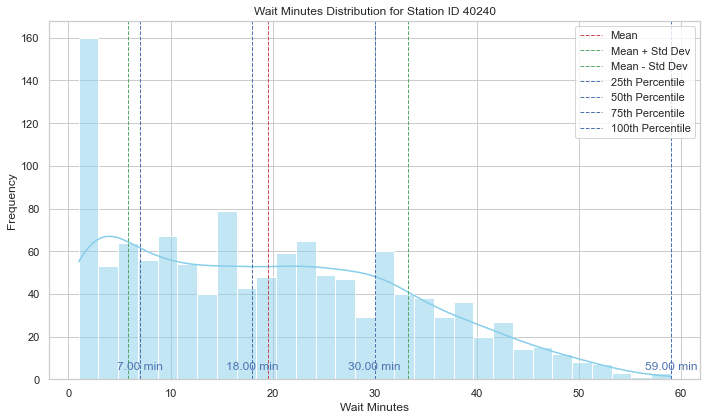

Average wait time: 19.58 minutes
Standard deviation of wait time: 13.71 minutes


In [13]:
# Get the list of unique station IDs
unique_stations = df['station_id'].unique()

print("List of unique station IDs:")
print(unique_stations)

# Prompt the user to input a station ID
station_id_input = int(input("\nEnter a station ID from the selection above to plot its 'wait_minutes' distribution: "))

# Filter the DataFrame for the selected station ID
selected_station_df = df[df['station_id'] == station_id_input]

# Calculate mean and standard deviation of wait_minutes for the selected station
mean_wait = selected_station_df['wait_minutes'].mean()
std_wait = selected_station_df['wait_minutes'].std()

# Calculate percentiles
percentiles = [25, 50, 75, 100]
percentile_values = np.percentile(selected_station_df['wait_minutes'], percentiles)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=selected_station_df, x='wait_minutes', bins=30, kde=True, color = 'skyblue')
plt.axvline(mean_wait, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_wait + std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean + Std Dev')
plt.axvline(mean_wait - std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean - Std Dev')

# Add percentile indicators
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, color='b', linestyle='dashed', linewidth=1, label=f'{p}th Percentile')
    plt.annotate(f'{value:.2f} min', (value, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='b')

plt.xlabel('Wait Minutes')
plt.ylabel('Frequency')
plt.title(f'Wait Minutes Distribution for Station ID {station_id_input}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average wait time: {mean_wait:.2f} minutes")
print(f"Standard deviation of wait time: {std_wait:.2f} minutes")

The 75th percentile of wait times, calculated for each station, serves as a robust threshold for identifying lateness. By using the 75th percentile, we capture instances where the wait time is higher than most occurrences.This approach accounts for variations in station-specific wait time distributions and avoids being overly sensitive to outliers or temporary fluctuations.

In [14]:
# Calculate the 75th percentile of wait_minutes for each station
station_75th_percentile = df.groupby('station_id')['wait_minutes'].quantile(0.75)

# Create a new column 'isLte' based on whether wait_minutes is above the 75th percentile
df['isLte'] = df.apply(lambda row: int(row['wait_minutes'] >= station_75th_percentile[row['station_id']]), axis=1)

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'station_avg_wait'
SAW_index = column_names.index('station_avg_wait')

# Move 'isLte' right after 'station_avg_wait'
column_names.insert(SAW_index + 1, column_names.pop(column_names.index('isLte')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
54937,40190,Red,2023-08-11 16:14:44,2023-08-11 16:30:44,16.0,15.431345,0,0,0,0,Sox-35th,95th/Dan Ryan,41.90392,-87.63141,7,7
94962,41450,Red,2023-08-18 18:01:15,2023-08-18 18:27:15,26.0,13.068399,1,0,0,0,Chicago,Howard,41.76497,-87.62569,68,68
98707,41260,G,2023-08-19 17:52:26,2023-08-19 18:08:26,16.0,23.674377,0,0,0,0,Austin,Harlem/Lake,41.88729,-87.77446,22,14
75598,40890,Blue,2023-08-13 18:35:16,2023-08-13 19:05:16,30.0,22.516176,0,0,0,0,O'Hare,O'Hare,41.92750,-87.70544,12,12
20816,40460,Brn,2023-08-10 17:39:47,2023-08-10 17:51:47,12.0,17.365456,0,0,0,0,Merchandise Mart,Kimball,41.88897,-87.63397,13,6
